In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime
import warnings
import pickle
from itertools import compress
warnings.filterwarnings('ignore')
% matplotlib inline

In [310]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

In [3]:
from model_generator_timeseries import *

### Generate df

In [4]:
paths_dict_band = json.load(open('inputs_json/paths_dict_band.json', 'r'))

In [5]:
band = generate_df(paths_dict_band, 'band', '2017-03-18')

In [6]:
df = band.return_completed_df()

In [7]:
name_list_24 = ['band']

In [8]:
feature_eng_df = band.return_df_feature_engineering(name_list_24)

In [9]:
features_list = json.load(open('inputs_json/feature_list_band_wo_hour_day_season_aemet.json', 'r'))

In [10]:
len(features_list)

85

### Train model timeseries based

In [11]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
pipeline = LGBMRegressor(num_leaves=40, learning_rate=0.02, n_estimators=1000)

In [12]:
lgbm_model_no_rolling = timeseries_model(feature_eng_df, features_list, 'band', 
                             '2016-01-01', '2017-03-17', 30, pipeline, rolling=False)

In [13]:
lgbm_model_no_rolling.obtain_cv_scores()

Acting on fold 10
Acting on fold 20
Acting on fold 30
Acting on fold 40
Acting on fold 50
Acting on fold 60
Acting on fold 70
Acting on fold 80
Acting on fold 90
Acting on fold 100
Acting on fold 110
Acting on fold 120
Acting on fold 130
Acting on fold 140
Acting on fold 150
Acting on fold 160
Acting on fold 170
Acting on fold 180
Acting on fold 190
Acting on fold 200
Acting on fold 210
Acting on fold 220
Acting on fold 230
Acting on fold 240
Acting on fold 250
Acting on fold 260
Acting on fold 270
Acting on fold 280
Acting on fold 290
Acting on fold 300
Acting on fold 310
Acting on fold 320
Acting on fold 330
Acting on fold 340
Acting on fold 350
Acting on fold 360
Acting on fold 370
Acting on fold 380
Acting on fold 390
Acting on fold 400
Acting on fold 410
Mean absolute error: 4.1703 +- 7.1548
Mean squared error: 51.5928 +- 390.2193


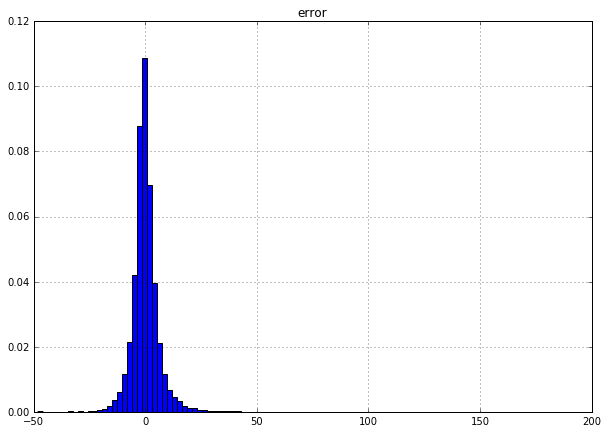

In [14]:
lgbm_model_no_rolling.plot_histogram_error()

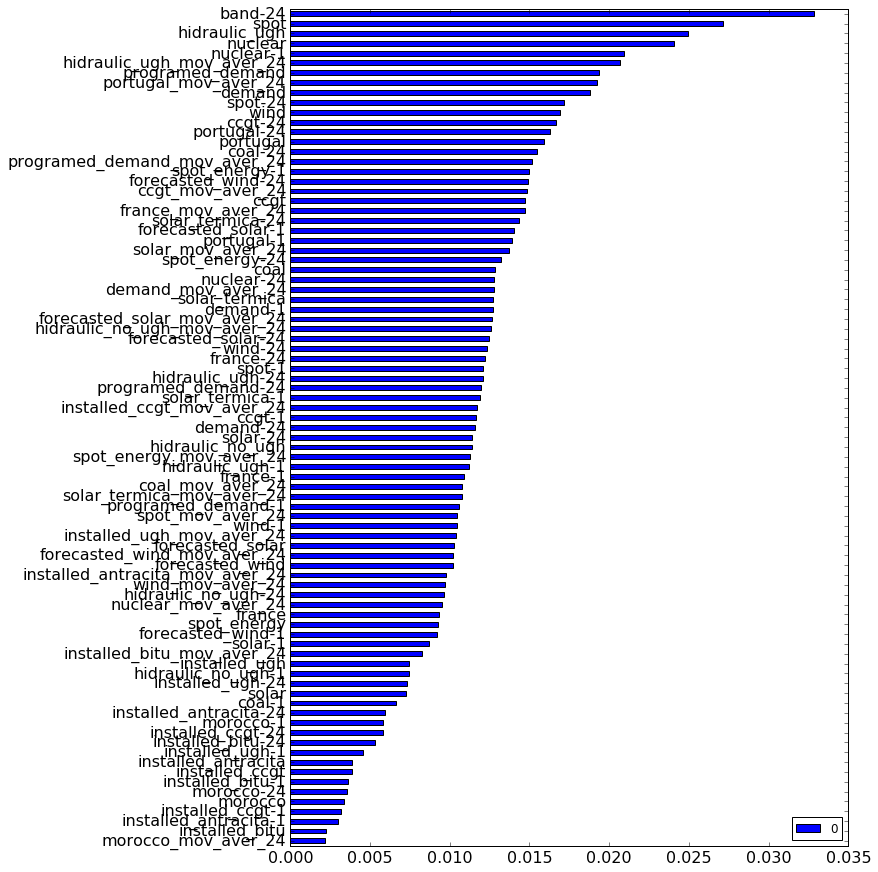

In [15]:
lgbm_model_no_rolling.get_feature_importance()

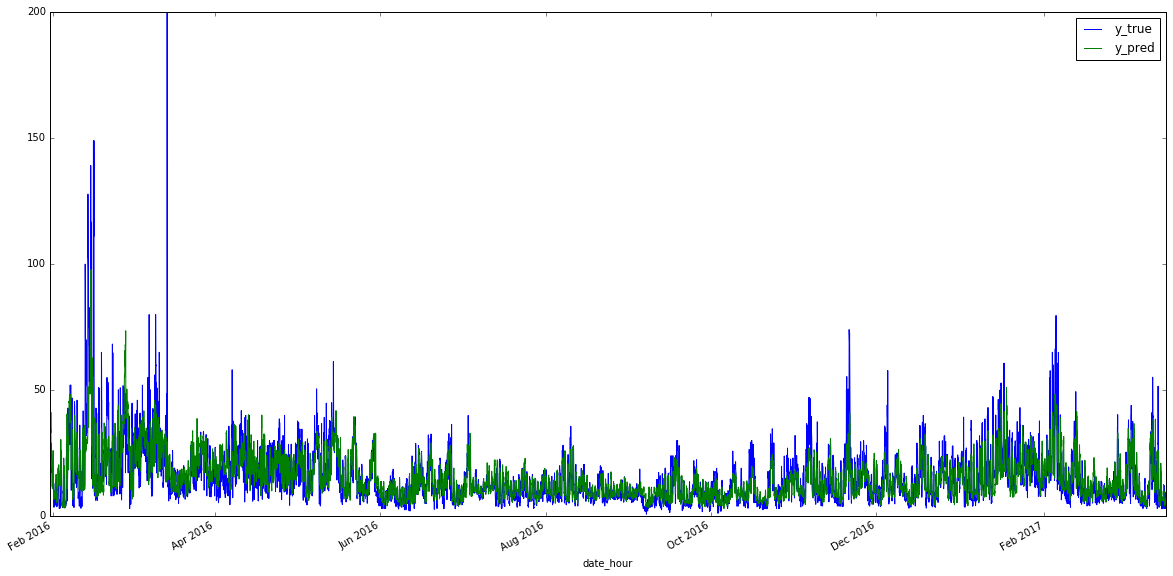

In [30]:
lgbm_model_no_rolling.result_df[['y_true', 'y_pred']].plot(figsize=(20,10));

In [24]:
lgbm_model_no_rolling.result_df.to_json('lgbm_predictions.json')

In [17]:
rf_pipeline = make_pipeline(Imputer(strategy='median'),
                          RandomForestRegressor(n_estimators=100, max_depth=9, 
                                                max_features='sqrt', max_leaf_nodes=200, 
                                                n_jobs=-1, random_state=0, min_samples_split=80,
                                               min_samples_leaf=25))

In [18]:
rf_model_no_rolling = timeseries_model(feature_eng_df, features_list, 'band', 
                             '2016-01-01', '2017-03-17', 30, rf_pipeline, rolling=False)

In [19]:
rf_model_no_rolling.obtain_cv_scores()

Acting on fold 10
Acting on fold 20
Acting on fold 30
Acting on fold 40
Acting on fold 50
Acting on fold 60
Acting on fold 70
Acting on fold 80
Acting on fold 90
Acting on fold 100
Acting on fold 110
Acting on fold 120
Acting on fold 130
Acting on fold 140
Acting on fold 150
Acting on fold 160
Acting on fold 170
Acting on fold 180
Acting on fold 190
Acting on fold 200
Acting on fold 210
Acting on fold 220
Acting on fold 230
Acting on fold 240
Acting on fold 250
Acting on fold 260
Acting on fold 270
Acting on fold 280
Acting on fold 290
Acting on fold 300
Acting on fold 310
Acting on fold 320
Acting on fold 330
Acting on fold 340
Acting on fold 350
Acting on fold 360
Acting on fold 370
Acting on fold 380
Acting on fold 390
Acting on fold 400
Acting on fold 410
Mean absolute error: 4.6872 +- 8.0738
Mean squared error: 59.9639 +- 417.7070


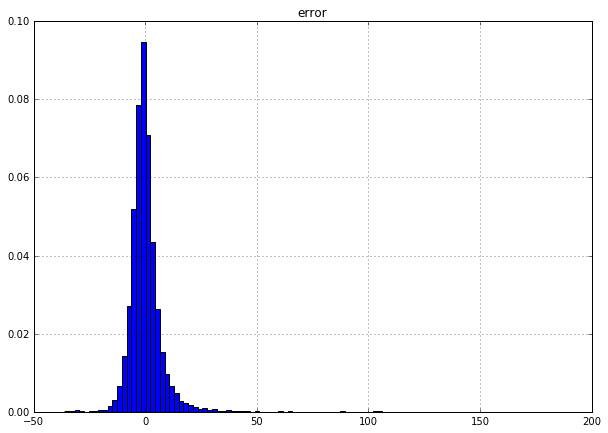

In [20]:
rf_model_no_rolling.plot_histogram_error()

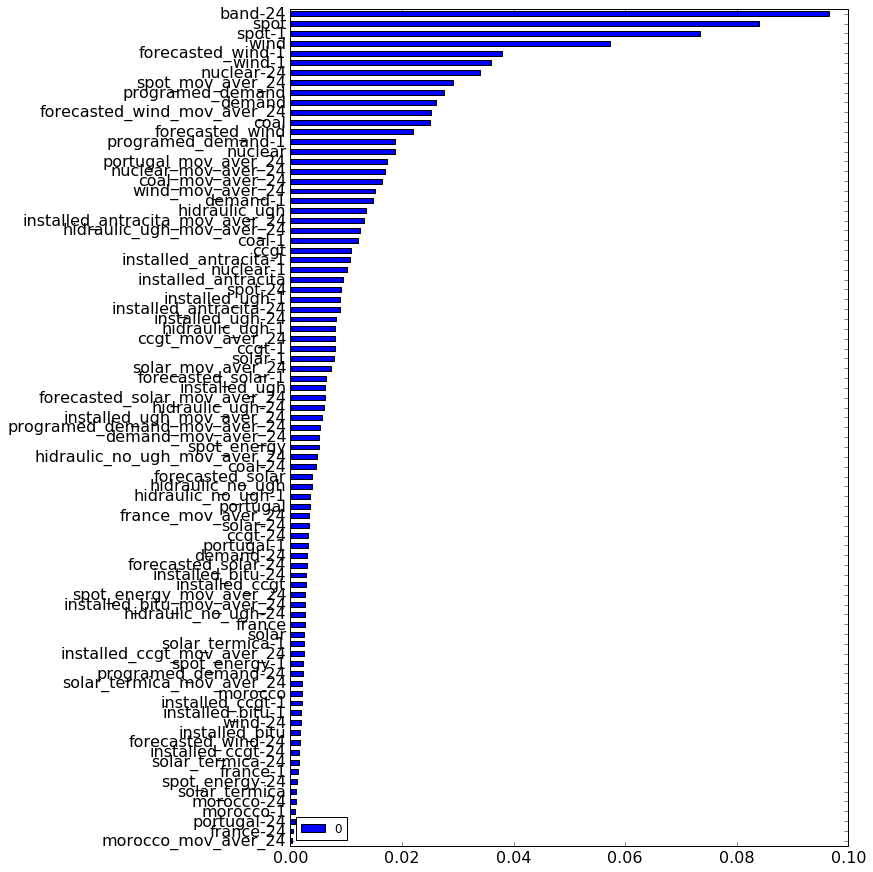

In [21]:
rf_model_no_rolling.get_feature_importance()

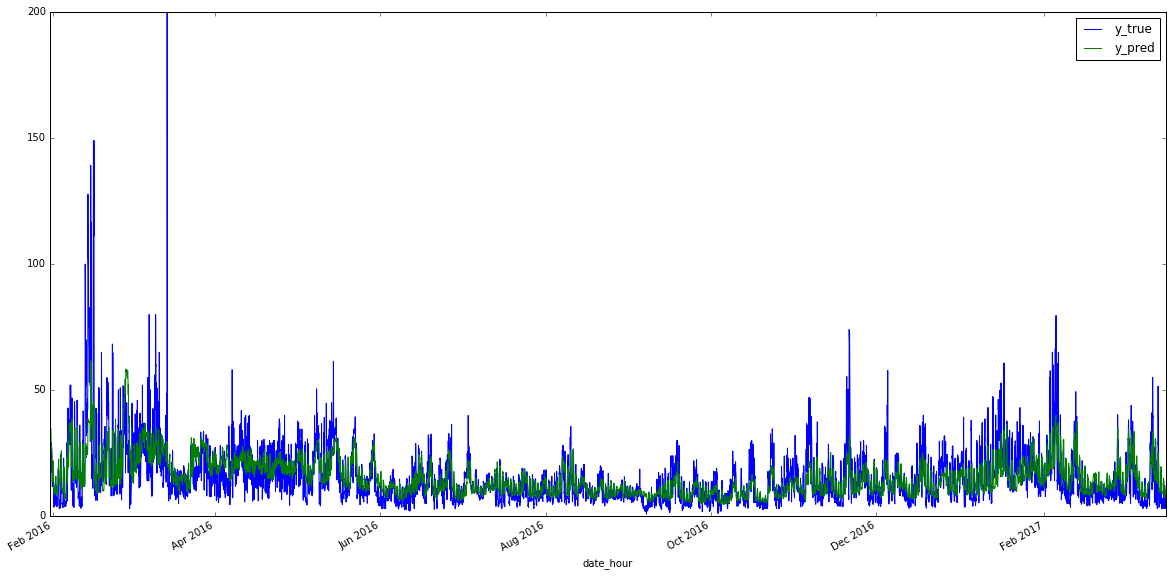

In [33]:
rf_model_no_rolling.result_df[['y_true','y_pred']].plot(figsize=(20,10));

In [27]:
rf_model_no_rolling.result_df.to_json('rf_predictions.json')

In [118]:
knn_pipeline = make_pipeline(Imputer(strategy='median'),StandardScaler(),
                                  KNeighborsRegressor(n_neighbors=20, weights='distance', 
                                                      leaf_size=30,p=2, n_jobs=-1))

In [119]:
knn_model_no_rolling = timeseries_model(feature_eng_df, features_list, 'band', 
                             '2016-01-01', '2017-03-17', 30, knn_pipeline, rolling=False)

In [120]:
knn_model_no_rolling.obtain_cv_scores()

Acting on fold 10
Acting on fold 20
Acting on fold 30
Acting on fold 40
Acting on fold 50
Acting on fold 60
Acting on fold 70
Acting on fold 80
Acting on fold 90
Acting on fold 100
Acting on fold 110
Acting on fold 120
Acting on fold 130
Acting on fold 140
Acting on fold 150
Acting on fold 160
Acting on fold 170
Acting on fold 180
Acting on fold 190
Acting on fold 200
Acting on fold 210
Acting on fold 220
Acting on fold 230
Acting on fold 240
Acting on fold 250
Acting on fold 260
Acting on fold 270
Acting on fold 280
Acting on fold 290
Acting on fold 300
Acting on fold 310
Acting on fold 320
Acting on fold 330
Acting on fold 340
Acting on fold 350
Acting on fold 360
Acting on fold 370
Acting on fold 380
Acting on fold 390
Acting on fold 400
Acting on fold 410
Mean absolute error: 4.8747 +- 7.8135
Mean squared error: 61.1220 +- 335.4577


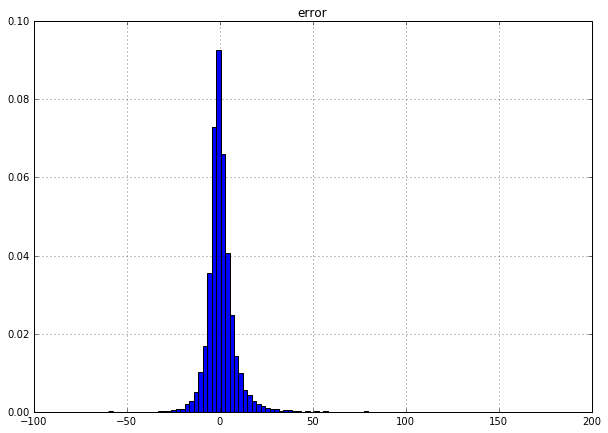

In [121]:
knn_model_no_rolling.plot_histogram_error()

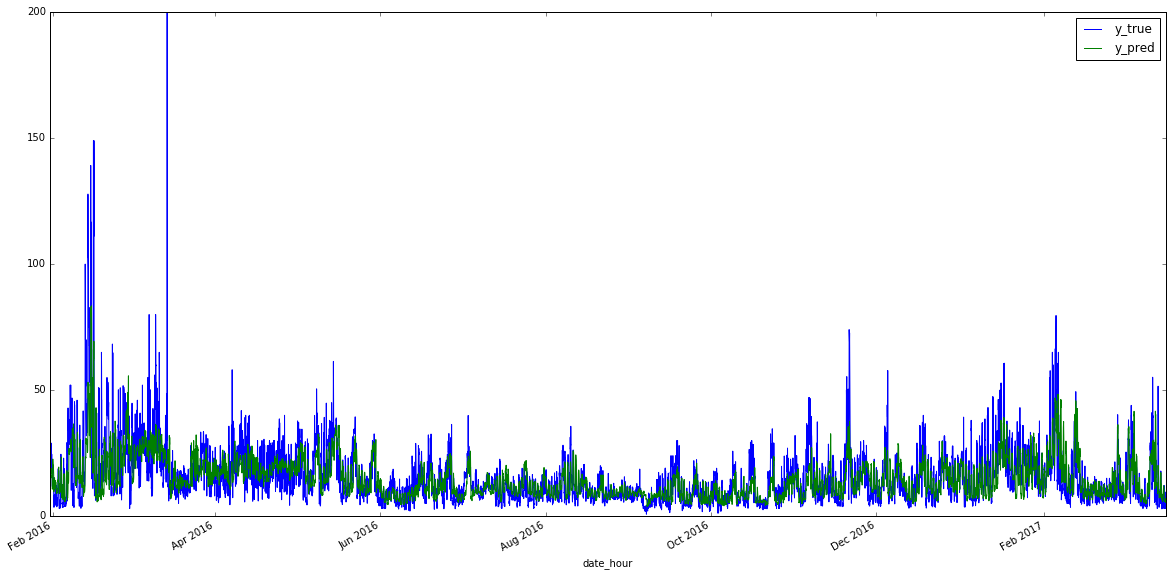

In [126]:
knn_model_no_rolling.result_df[['y_true', 'y_pred']].plot(figsize=(20,10));

In [127]:
knn_model_no_rolling.result_df.to_json('knn_predictions.json')

### Stacked model

In [128]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.feature_selection import SelectFromModel

In [303]:
pipeline_stack = make_pipeline(Imputer(strategy='median'), StandardScaler(), SelectFromModel(Lasso(alpha=1, random_state=0)),
                               Ridge(alpha=200, random_state=0))

In [161]:
lgbm_df = lgbm_model_no_rolling.result_df[['y_true', 'y_pred']].rename(columns={'y_pred':'lgbm', 'y_true':'band'})
rf_df = rf_model_no_rolling.result_df[['y_pred']].rename(columns={'y_pred':'rf'})
knn_df = knn_model_no_rolling.result_df[['y_pred']].rename(columns={'y_pred':'knn'})

stack_df = lgbm_df.merge(pd.concat([knn_df, rf_df], axis=1), how='left', left_index=True, right_index=True)

In [162]:
stack_df['hour'] = stack_df.index.hour

weekday_dict = {
    0:'L', 1:'M', 2:'X', 3:'J', 4:'V', 5:'S', 6:'D' 
}
stack_df['date'] = pd.to_datetime(stack_df.index.date)
stack_df['weekday'] = pd.to_datetime(stack_df['date']).dt.dayofweek
stack_df.replace({'weekday':weekday_dict}, inplace=True)

for feature in ['hour', 'weekday']:
    stack_df[pd.get_dummies(stack_df[feature], drop_first=True).columns.tolist()] = pd.get_dummies(stack_df[feature], drop_first=True)

In [165]:
features_stack_list = [ element for element in stack_df.columns.tolist() if element not in ['band', 'hour', 'date', 'weekday']]

In [167]:
stack_df_train_test = stack_df.iloc[:-24]
stack_validation = stack_df.iloc[-24:]

In [304]:
stack_model_no_rolling = timeseries_model(stack_df_train_test, features_stack_list, 'band', 
                             '2016-01-31', '2017-03-16', 30, pipeline_stack, rolling=False)

In [305]:
stack_model_no_rolling.obtain_cv_scores()

Acting on fold 10
Acting on fold 20
Acting on fold 30
Acting on fold 40
Acting on fold 50
Acting on fold 60
Acting on fold 70
Acting on fold 80
Acting on fold 90
Acting on fold 100
Acting on fold 110
Acting on fold 120
Acting on fold 130
Acting on fold 140
Acting on fold 150
Acting on fold 160
Acting on fold 170
Acting on fold 180
Acting on fold 190
Acting on fold 200
Acting on fold 210
Acting on fold 220
Acting on fold 230
Acting on fold 240
Acting on fold 250
Acting on fold 260
Acting on fold 270
Acting on fold 280
Acting on fold 290
Acting on fold 300
Acting on fold 310
Acting on fold 320
Acting on fold 330
Acting on fold 340
Acting on fold 350
Acting on fold 360
Acting on fold 370
Acting on fold 380
Mean absolute error: 3.9060 +- 5.0956
Mean squared error: 35.3320 +- 166.4610


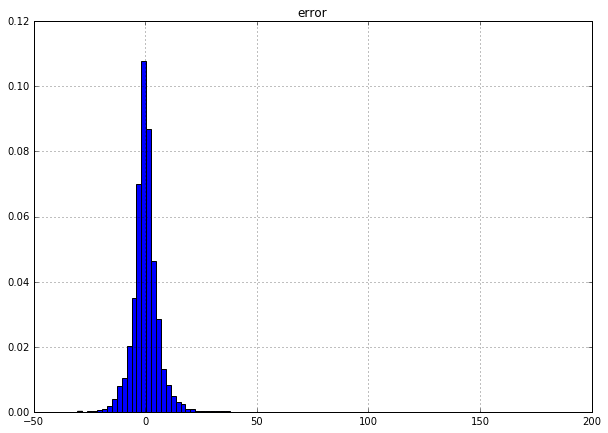

In [306]:
stack_model_no_rolling.plot_histogram_error()

In [307]:
stack_model_no_rolling.get_feature_importance()

                   0
intercept  15.428959
lgbm        6.068778
knn         2.979914


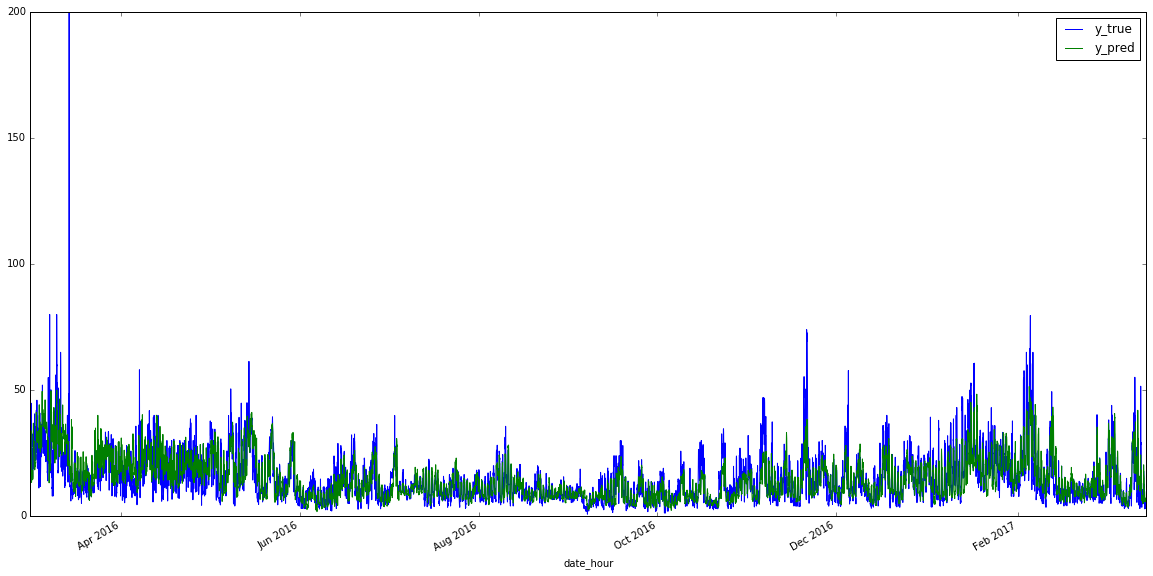

In [327]:
stack_model_no_rolling.result_df[['y_true', 'y_pred']].plot(figsize=(20,10));

#### Prediction for last unseen day

Mean absolute error for desired day: 1.5418


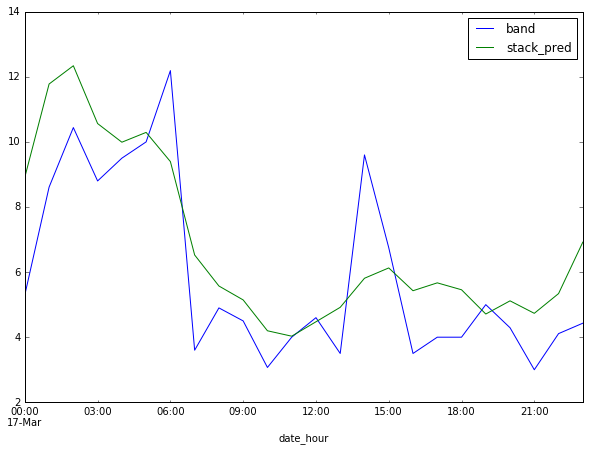

In [311]:
day_to_predict = pd.DataFrame({'stack_pred':stack_model_no_rolling.pipeline.predict(stack_validation[features_stack_list].values),
             'band':stack_validation['band']})
print('Mean absolute error for desired day: %.4f' %mean_absolute_error(day_to_predict['band'], day_to_predict['stack_pred']))
day_to_predict.plot(figsize=(10,7));

In [334]:
stack_validation.to_json('json/stack_validation_day.json', orient='index', date_format='iso')

#### Residuals of stack model

In [328]:
Y_log = np.log1p(stack_model_no_rolling.result_df['y_true'])
Y_pred_log = np.log1p(stack_model_no_rolling.result_df['y_pred'])
residuals_log = pd.DataFrame({'log_res':Y_log - Y_pred_log}, index=stack_model_no_rolling.result_df.index)

Export models

In [322]:
with open('saved_models/lgbm_pipeline.p', 'wb') as f:
    pickle.dump(lgbm_model_no_rolling.pipeline, f)
    
with open('saved_models/rf_pipeline.p', 'wb') as f:
    pickle.dump(rf_model_no_rolling.pipeline, f)
    
with open('saved_models/knn_pipeline.p', 'wb') as f:
    pickle.dump(knn_model_no_rolling.pipeline, f)
    
with open('saved_models/stack_pipeline.p', 'wb') as f:
    pickle.dump(stack_model_no_rolling.pipeline, f)

Export residuals

In [332]:
with open('json/feature_list_band_stack.json', 'w') as f:
    json.dump([str(element) for element in stack_model_no_rolling.features_list], f)

residuals_log.to_json('json/residuals_stack.json', orient='index', date_format='iso')